In [30]:
import os
print(os.listdir("."))

# Authorization for Google Colab
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Mount drive to "drive/" folder
!fusermount -u drive
!mkdir -p drive
#except:
#  pass
!google-drive-ocamlfuse drive

# Change Working directory
print(os.listdir("drive/"))
os.chdir("drive/variable-classifier/NN/periodicnetwork-master/")
print(os.listdir("."))

['light_curve.py', '_train_new.py', '_train.pyc', 'train.py', 'data_ppmnist.py', 'variablestar.sh', 'resnet_original.py', '_train_og.py', 'rnn.py', 'keming_results', 'Untitled0.ipynb', 'RunTrain.ipynb', 'data.pyc', 'Ogle III Data.desktop', '_train.py', 'drive', 'wandb', 'variablestar_og.sh', 'train_og.py', 'rnn.pyc', 'RunTrain_and_Compare.ipynb', '__pycache__', 'train_wandb.py', 'itcn.pyc', 'Untitled1.ipynb', 'itcn.py', 'data', 'class_hierarchy.py', 'util.py', 'ppmnist.sh', 'data.py', 'results', 'padding.py', 'itin.pyc', 'padding.pyc', 'resnet.pyc', 'requirements.txt', 'hyperparam.yaml', 'Copy of RunTrain_and_Compare.ipynb', 'util.pyc', 'light_curve.pyc', 'hyperparam_simple.yaml', 'resnet.py', 'README.md', 'trained_networks.tar', 'model', 'train_new.py', 'ppmnist.py', 'itin.py']
E: Package 'python-software-properties' has no installation candidate
··········
fusermount: failed to unmount /content/drive/variable-classifier/NN/periodicnetwork-master/drive/variable-classifier/NN/periodicn

In [31]:
import os, glob
import gzip, tarfile
import joblib
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
from light_curve import LightCurve

from astropy.stats import sigma_clip
!pip install gatspy
from gatspy.periodic import LombScargle

from tqdm import tqdm_notebook

sb.set(style="ticks", color_codes=True, context="paper", font_scale=1.5)
sb.set_style({"xtick.direction": "in","ytick.direction": "in"})

main_path = os.path.dirname(os.getcwd())

save_plots = False
save_tables = False

In [43]:
#Modified version of functions from https://github.com/jorgemarpa/PELS-VAE/blob/master/notebooks/preprocess_OGLE3.ipynb
def preprocess_lc(lc, sig=3, ite=3):
    # sigma clipping in phot outlier
    clip_mag = sigma_clip(lc[:,1], sigma=sig,
                          maxiters=ite, cenfunc=np.median,
                          copy=False)
    # sigma clipping in err values
    clip_err = sigma_clip(lc[:,2], sigma=sig,
                          maxiters=ite, cenfunc=np.median,
                          copy=False)
    lc = lc[(~clip_mag.mask) & (~clip_err.mask)]
    return lc

def subsample(lc, nb=200):
    # undersample light curve to nb observations
    # if len(lc) > nb, undersample 
    # else, concatenate true lc with extra observations
    # sampled from N(m, m_err)
    if len(lc.measurements) >= nb:
        new_lc = copy_lc(lc)#lc.copy()
        ind = np.random.choice(len(lc.measurements), size=nb, replace=False)
        new_lc.measurements = lc.measurements[ind]
        new_lc.times = lc.times[ind]
        new_lc.errors = lc.errors[ind]
        return new_lc
    else:
        ind = np.random.choice(len(lc.measurements), size=nb-len(lc.measurements), replace=True)
        extra = sample_err(lc)[ind]
        return np.vstack([lc, extra])

def sample_err(lc):
    # resample observations from N(m, m_err)
    new_lc = copy_lc(lc)#lc.copy()
    new_lc.measurements = np.random.normal(loc=lc.measurements, scale=lc.errors)
    return new_lc

def copy_lc(lc):
  return LightCurve(lc.times, lc.measurements, lc.errors, survey=lc.survey, name=lc.name, best_period=lc.best_period, best_score=lc.best_score, label=lc.label, p=lc.p, p_signif=lc.p_signif, p_class=lc.p_class, ss_resid=lc.ss_resid)

In [33]:
#My functions
def give_me_lc(filename='ogle_data.pkl', force=True):
    
    data = joblib.load('data/{}'.format(filename))
    for lc in data:
        positive = lc.errors > 0
        positive *= lc.errors < 99
        lc.times = lc.times[positive]
        lc.measurements = lc.measurements[positive]
        lc.errors = lc.errors[positive]
        lc.p = abs(float(lc.p))

    return data

In [61]:
data = give_me_lc()
unique_label, count = np.unique([lc.label for lc in data], return_counts=True)
target = [5000 if c < 2000 else 10000 for c in count]
label2count = {unique_label[i]:count[i] for i in range(len(count))}
label2target = {unique_label[i]:target[i] for i in range(len(target))}

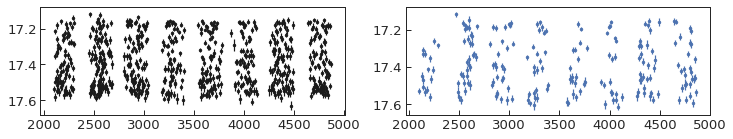

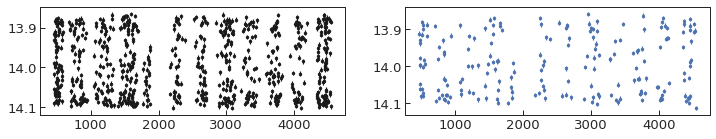

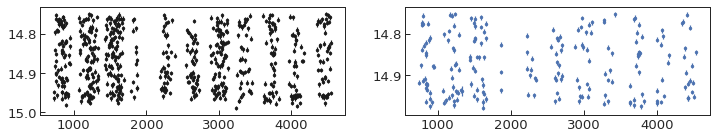

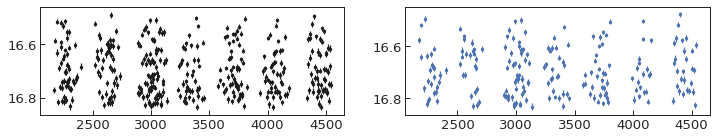

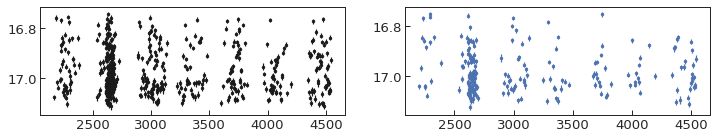

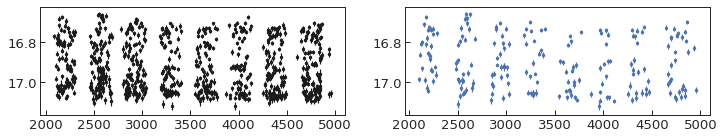

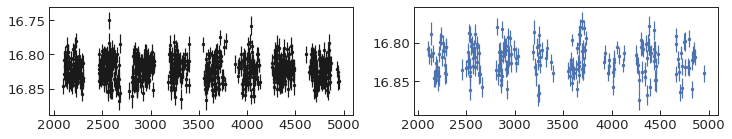

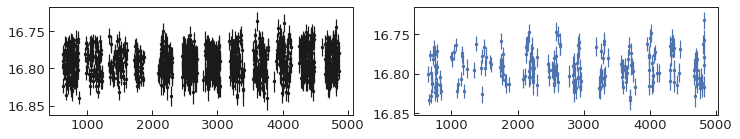

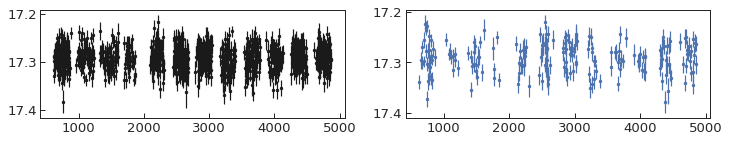

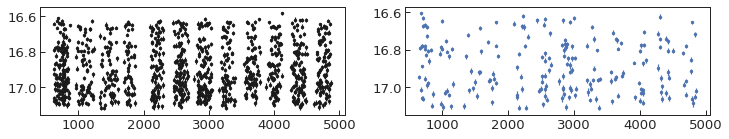

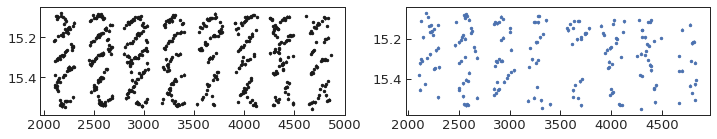

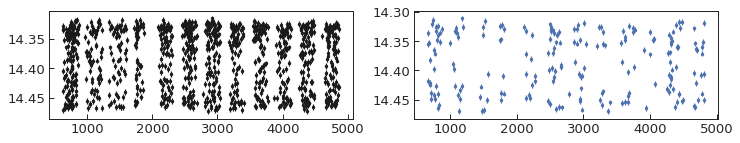

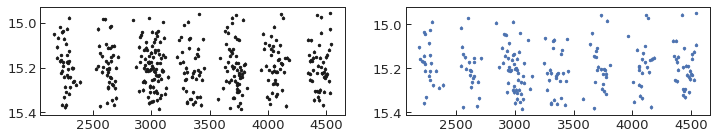

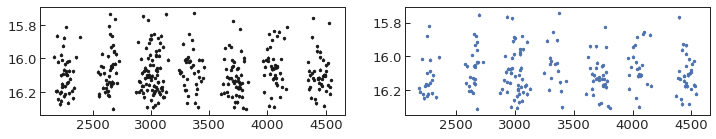

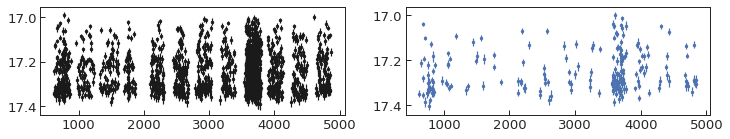

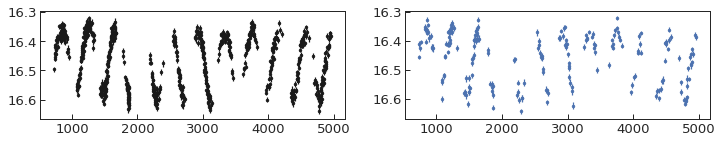

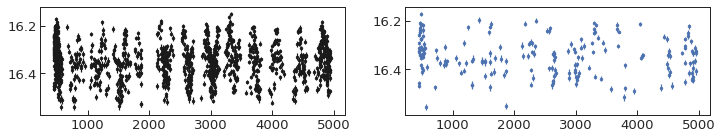

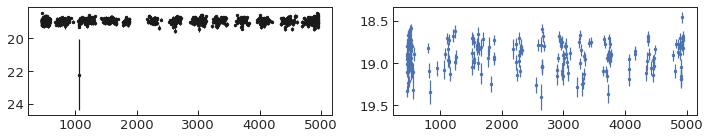

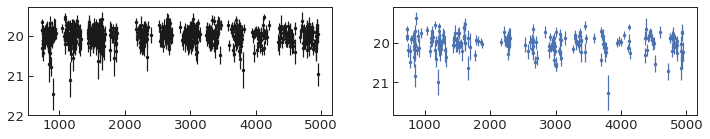

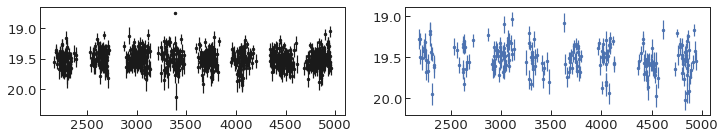

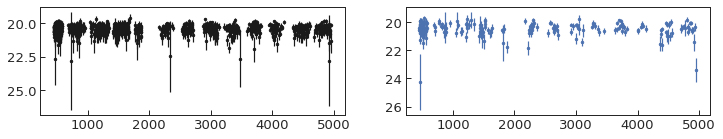

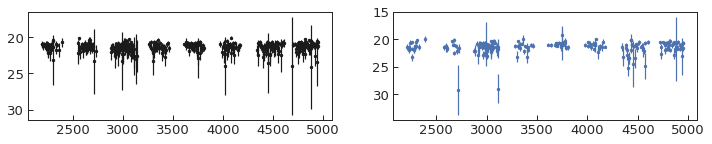

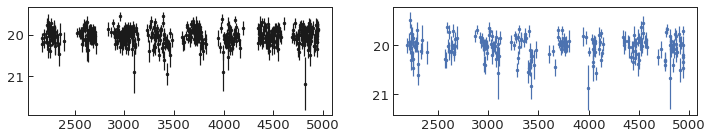

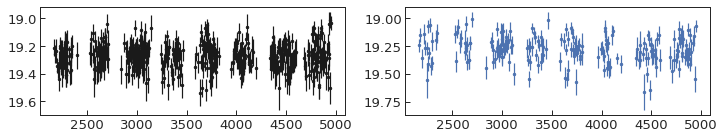

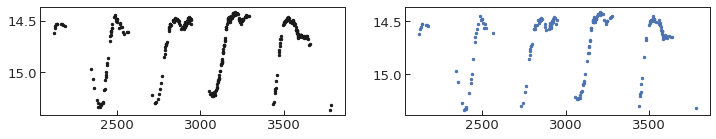

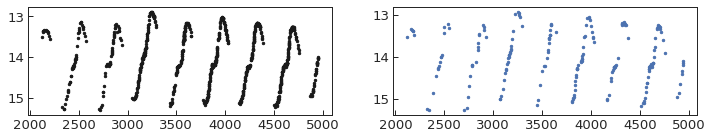

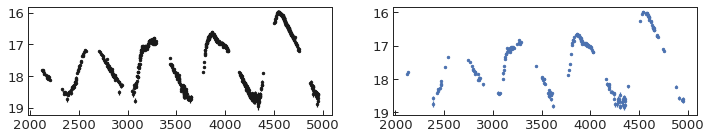

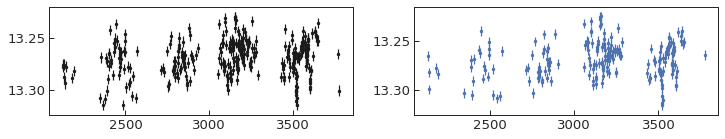

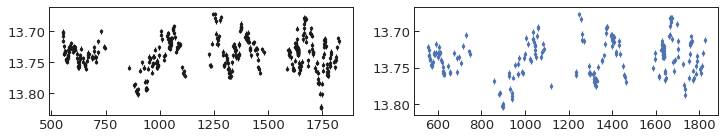

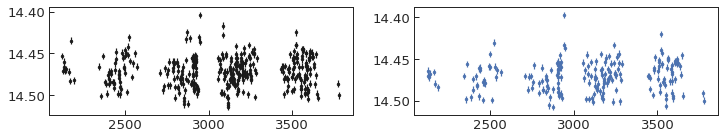

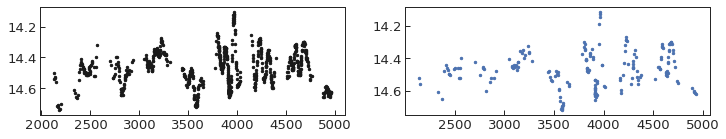

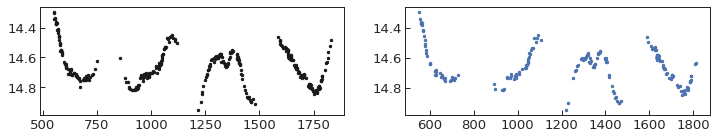

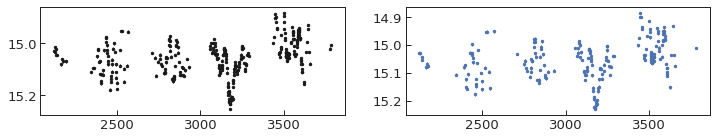

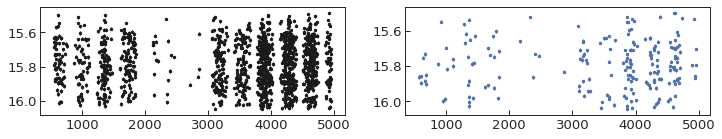

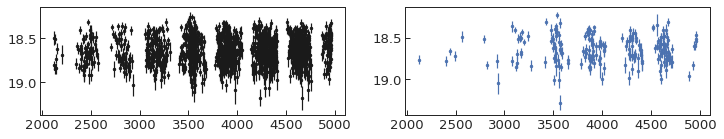

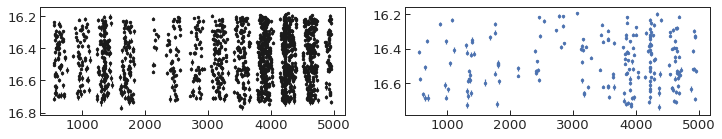

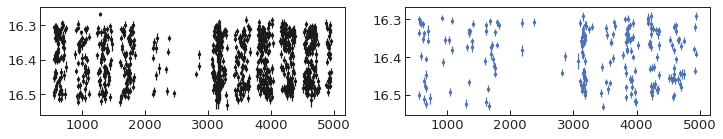

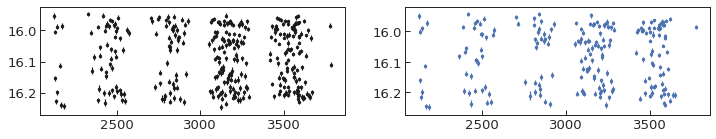

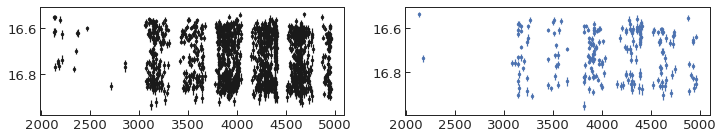

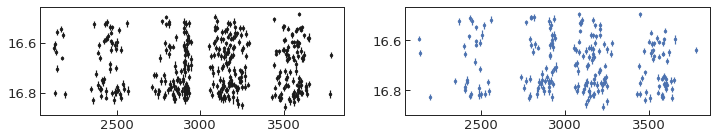

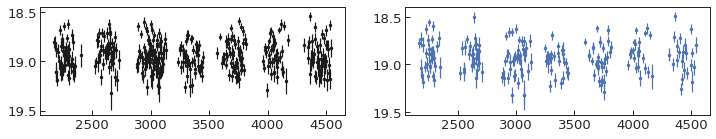

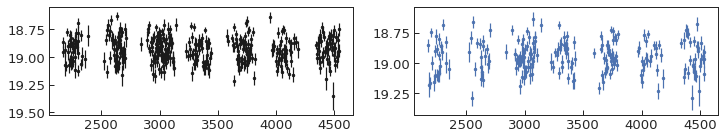

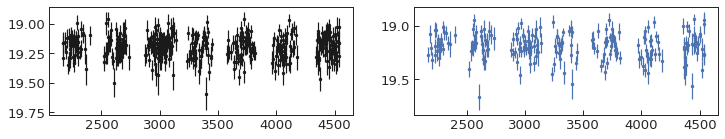

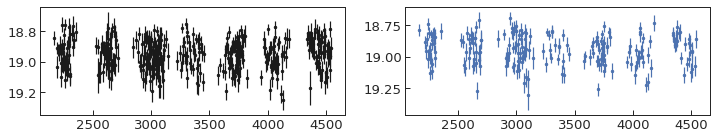

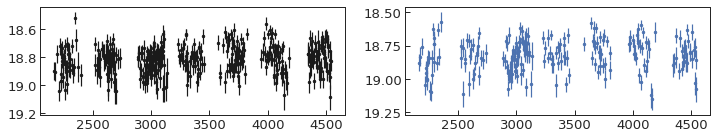

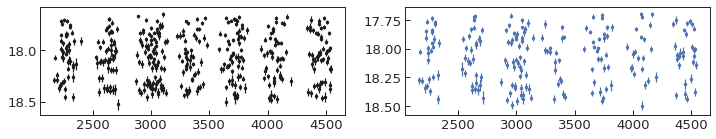

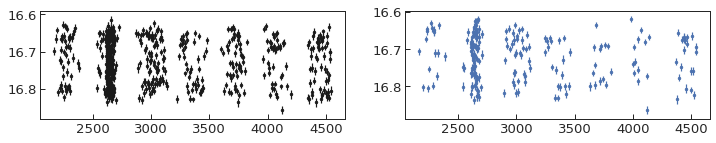

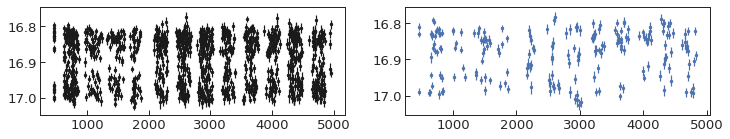

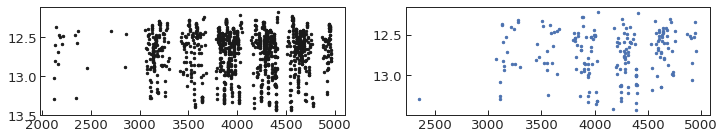

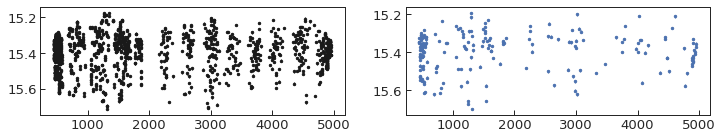

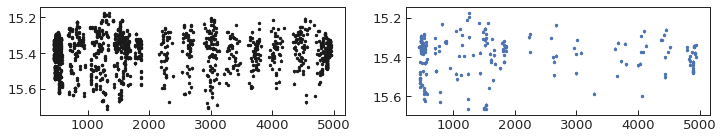

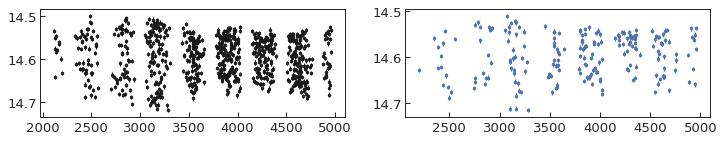

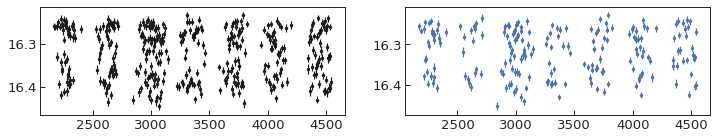

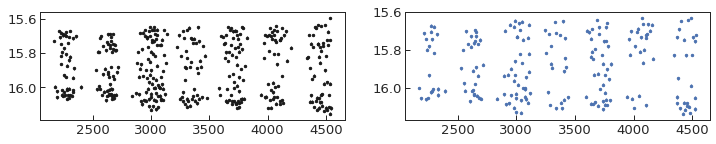

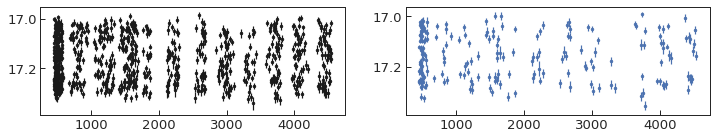

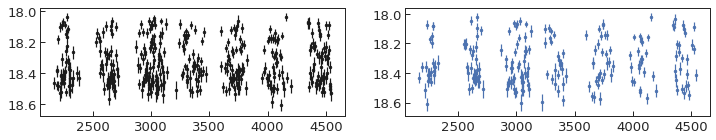

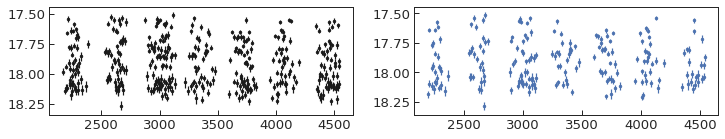

In [62]:
NB = 200
Plot = True
aug_lcs = []
for label in unique_label: #k, (vt, nn) in enumerate(meta_new.Type.value_counts().sort_index().items()):
    count = label2count[label]
    target = label2target[label]
    class_data = [lc for lc in data if lc.label == label]
    aa = 0
    while count < target:
        rnd_idx = np.random.choice(len(class_data))
        org_lc = class_data[rnd_idx]
        P = org_lc.p
        new_lc = subsample(sample_err(org_lc), nb=NB)
        aug_lcs.append(new_lc)
        count += 1
               
        if np.random.uniform() > .95 and aa < 3 and Plot:
            f, ax = plt.subplots(1,2, figsize=(12,2))
            ax[0].errorbar(org_lc.times, org_lc.measurements, yerr=org_lc.errors, 
                           fmt='.', c='k')
            ax[1].errorbar(new_lc.times, new_lc.measurements, yerr=new_lc.errors, 
                           fmt='.', c='b')
            ax[0].invert_yaxis()
            ax[1].invert_yaxis()
            plt.show()
            aa += 1

In [63]:
data = data + aug_lcs
unique_label, count = np.unique([lc.label for lc in data], return_counts=True)
label2count = {unique_label[i]:count[i] for i in range(len(count))}
print(label2count)

{'Cep_1': 10000, 'Cep_12': 5000, 'Cep_2': 5000, 'Cep_F': 10000, 'Cep_F1': 5000, 'DPV': 5000, 'DSCT_F1': 5000, 'DSCT_S': 10000, 'LPV_Mira': 5000, 'LPV_OSARG': 10000, 'LPV_SRV': 5000, 'RRLyr_RRab': 10000, 'RRLyr_RRc': 10000, 'RRLyr_RRd': 5000, 'RRLyr_RRe': 5000, 'T2Cep_BLHer': 5000, 'T2Cep_RVTau': 5000, 'T2Cep_WVir': 5000, 'aCep_F': 5000}


In [64]:
len(data), len(aug_lcs)

(125000, 92041)

In [ ]:
outname = 'data/ogle_data_aug.pkl'
joblib.dump(data, outname)